In [1]:
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import xarray as xr

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1


## 1. Coordinates, Distributors, and Bases

### 1.1: Coordinates

In [2]:
# Simulation units
meter = 1 / 6.37122e6
hour = 1
second = hour / 3600
day = hour*24

# Parameters
Nphi = 128
Ntheta = 64
dealias = (3/2, 3/2)
R = 8.2e7 * meter
Omega = 3.2e-5 / second
g = 20 * meter / second**2
H0 = 4e6 * meter**2/second**2/g
DeltaHeq = 0.01*H0

taudrag = 10 * day
taurad = taudrag


dtype = np.float64
nu = 1e5 * meter**2 / second / 32**2 # hyperdiffusion constant



# Bases
coords = d3.S2Coordinates('phi', 'theta')
dist = d3.Distributor(coords, dtype=dtype)
full_basis = d3.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=dealias, dtype=dtype)
#zonal_basis = d3.SphereBasis(coords, (1, Ntheta), radius=R, dealias=dealias, dtype=dtype)


In [3]:
# Fields
u = dist.VectorField(coords, name='u', bases=full_basis)
h = dist.Field(name='h', bases=full_basis)
heq = dist.Field(name='heq', bases=full_basis)


In [4]:
ephi = dist.VectorField(coords, bases=full_basis)
ephi['g'][0] = 1
etheta = dist.VectorField(coords, bases=full_basis)
etheta['g'][1] = 1

In [5]:
#lat0 = 0.
#Deltalat=20.*np.pi/180.
phi, theta = dist.local_grids(full_basis)
lat = np.pi/2-theta
heq['g'] = H0 + DeltaHeq*np.cos(phi)*np.cos(lat)#np.exp(-((lat-lat0)/Deltalat)**2)
h['g'] = heq['g']

In [6]:
# cross product by zhat
zcross = lambda A: d3.MulCosine(d3.skew(A))

In [7]:
# Timestepping parameters
timestep = 0.1*hour
stop_sim_time = 2*day

# Problem
problem = d3.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + nu*lap(lap(u)) + g*grad(h) + 2*Omega*zcross(u) + u/taudrag = - u@grad(u)")
problem.add_equation("dt(h) + nu*lap(lap(h)) + h/taurad = - div(u*h) + heq/taurad")

# Solver
solver = problem.build_solver(d3.RK222)
solver.stop_sim_time = stop_sim_time

# CFL
#CFL = d3.CFL(solver, initial_dt=timestep, cadence=1, safety=0.2, threshold=0.,max_change=1.5, min_change=0.1, max_dt=100*timestep)
#CFL.add_velocity(u)

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=0.1*hour)
snapshots.add_task(h, name='height')
#snapshots.add_task(-d3.div(d3.skew(u)), name='vorticity')
snapshots.add_task(u@ephi, name='u')
snapshots.add_task(-u@etheta, name='v')

2023-06-30 16:33:38,309 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 4s, Rate: 1.5e+01/s
2023-06-30 16:33:38,497 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 2s, Rate: 2.7e+01/s
2023-06-30 16:33:38,738 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 2s, Rate: 2.8e+01/s
2023-06-30 16:33:38,950 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 1s, Remaining: 1s, Rate: 3.0e+01/s
2023-06-30 16:33:39,138 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 3.1e+01/s
2023-06-30 16:33:39,313 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 1s, Rate: 3.3e+01/s
2023-06-30 16:33:39,511 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 1s, Rate: 3.3e+01/s
2023-06-30 16:33:39,701 subsystems 0/1 INFO :: Building subproblem matri

In [8]:
%%time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        #timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2023-06-30 16:33:40,075 __main__ 0/1 INFO :: Starting main loop
2023-06-30 16:33:45,173 __main__ 0/1 INFO :: Iteration=1, Time=1.000000e-01, dt=1.000000e-01
2023-06-30 16:33:47,432 __main__ 0/1 INFO :: Iteration=21, Time=2.100000e+00, dt=1.000000e-01
2023-06-30 16:33:50,115 __main__ 0/1 INFO :: Iteration=41, Time=4.100000e+00, dt=1.000000e-01
2023-06-30 16:33:52,559 __main__ 0/1 INFO :: Iteration=61, Time=6.100000e+00, dt=1.000000e-01
2023-06-30 16:33:54,951 __main__ 0/1 INFO :: Iteration=81, Time=8.100000e+00, dt=1.000000e-01
2023-06-30 16:33:57,258 __main__ 0/1 INFO :: Iteration=101, Time=1.010000e+01, dt=1.000000e-01
2023-06-30 16:33:59,584 __main__ 0/1 INFO :: Iteration=121, Time=1.210000e+01, dt=1.000000e-01
2023-06-30 16:34:01,901 __main__ 0/1 INFO :: Iteration=141, Time=1.410000e+01, dt=1.000000e-01
2023-06-30 16:34:04,116 __main__ 0/1 INFO :: Iteration=161, Time=1.610000e+01, dt=1.000000e-01
2023-06-30 16:34:07,213 __main__ 0/1 INFO :: Iteration=181, Time=1.810000e+01, dt=1.000

In [16]:
sol = xr.open_dataset('snapshots/snapshots_s1.h5',engine='dedalus')
sol = sol.assign_coords({'longitude':(sol.phi-np.pi)*180/np.pi,'latitude':(np.pi/2-sol.theta)*180/np.pi}).swap_dims({'phi':'longitude','theta':'latitude'})

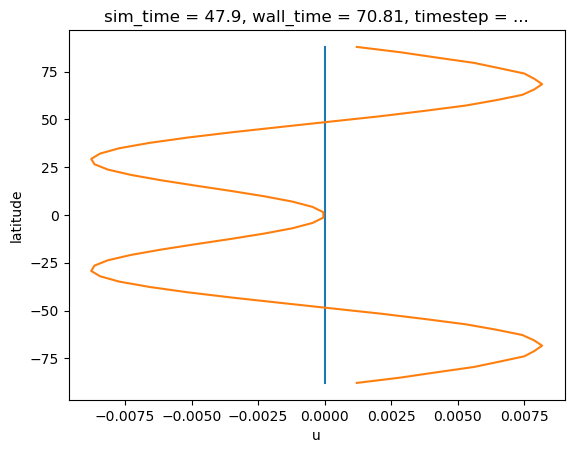

In [12]:
(sol.u.mean('longitude')[0]  /(meter/second)).plot(y='latitude')
(sol.u.mean('longitude')[-1] /(meter/second)).plot(y='latitude')

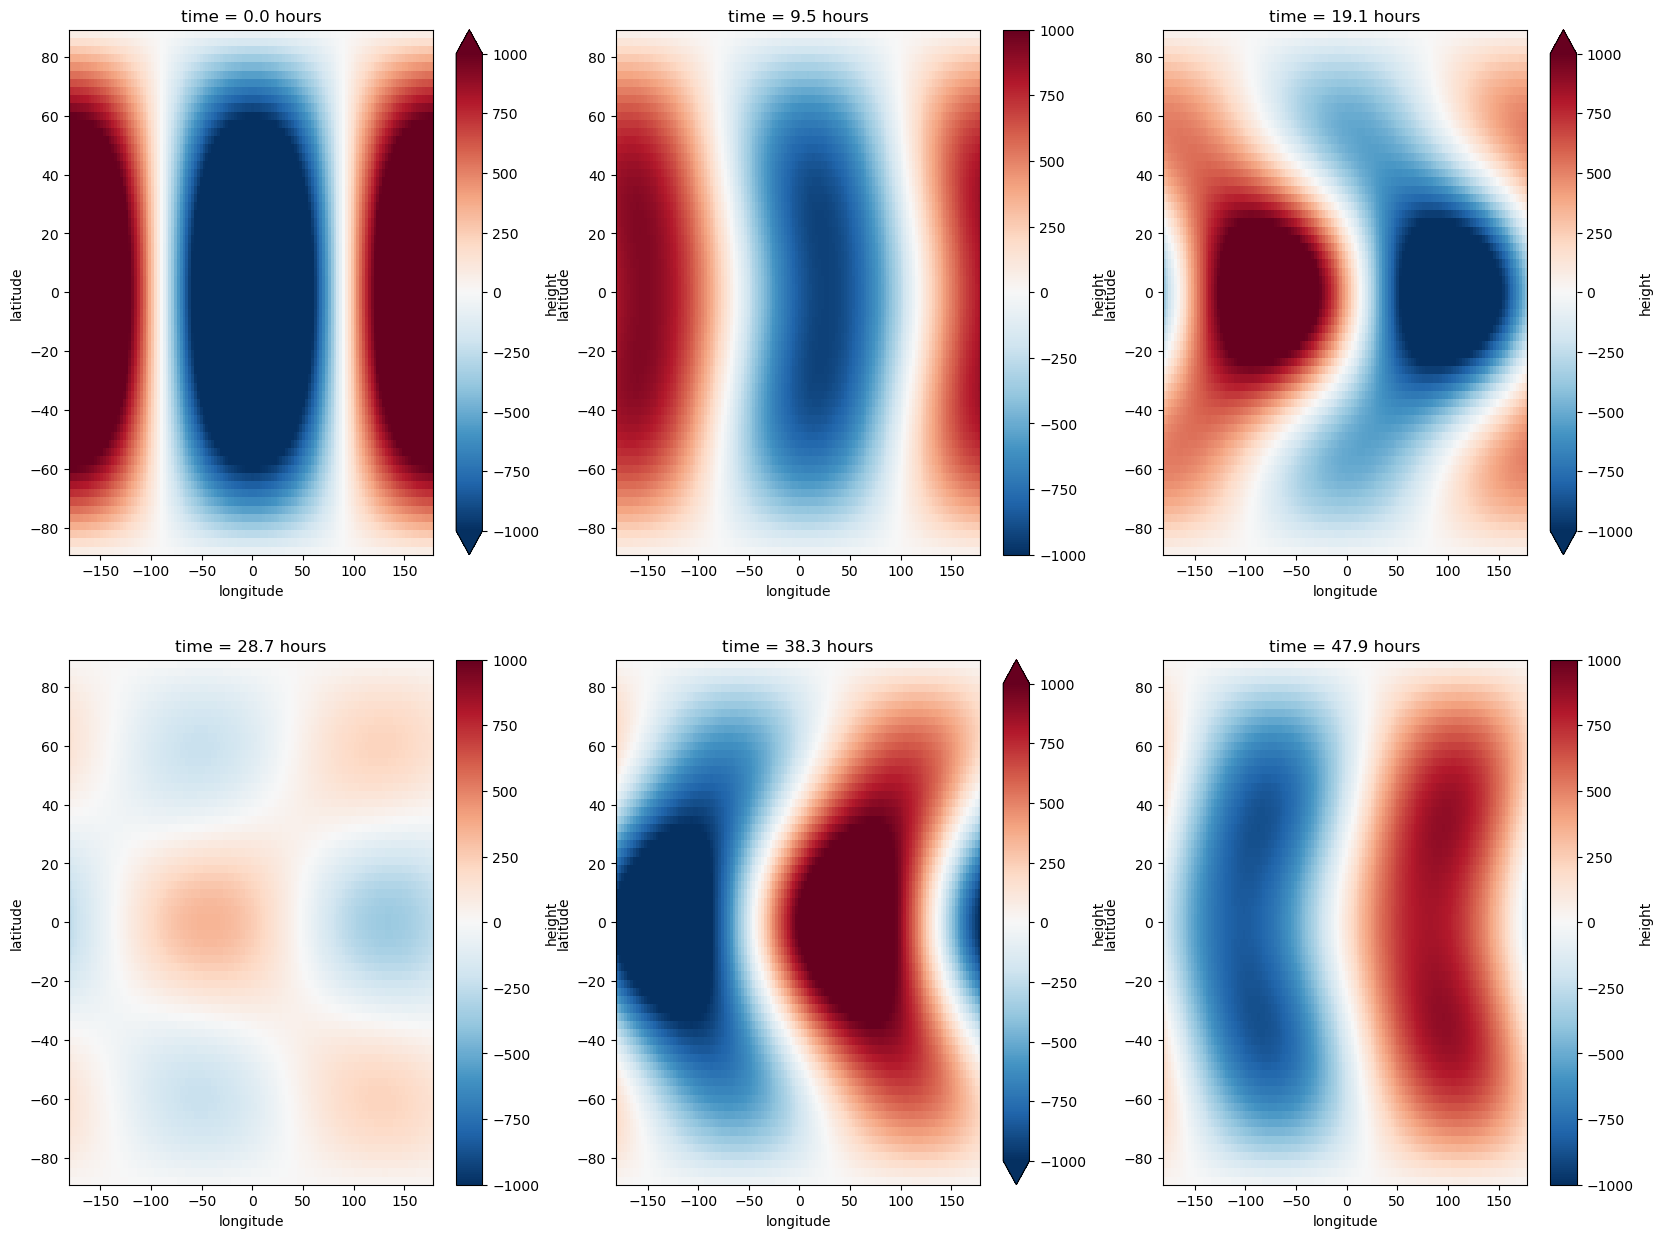

In [18]:
_,axs=plt.subplots(2,3,figsize=(20,15))
axs=axs.reshape(-1)
for i,time in enumerate(np.linspace(0,len(sol.t)-1,6)):
    time=int(time)
    ((sol.height[time]-H0)/meter).plot(ax=axs[i],y='latitude',vmin=-1e3,vmax=1e3,cmap=plt.cm.RdBu_r)
    #axs[i].set_xlim(-90,90)
    axs[i].set_title("time = %.1f hours"%sol.t[time])

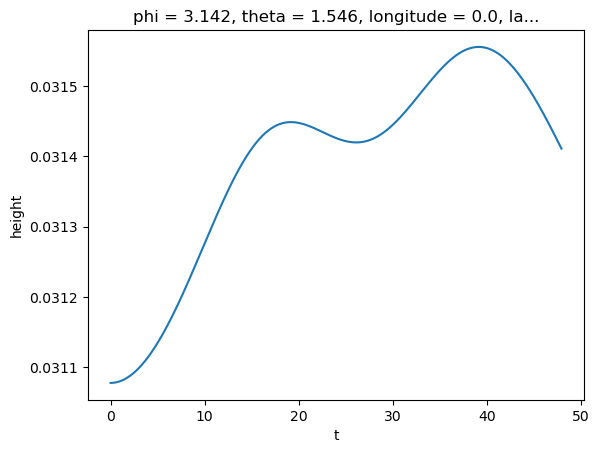

In [14]:
sol.height.sel(longitude=0.,latitude=0.,method='nearest').plot()

# plotting from mpi output

In [ ]:
sol1 = xr.open_dataset('snapshots/snapshots_s1/snapshots_s1_p0.h5',engine='dedalus')
#sol = sol.assign_coords({'longitude':(sol.phi-np.pi)*180/np.pi,'latitude':(np.pi/2-sol.theta)*180/np.pi}).swap_dims({'phi':'longitude','theta':'latitude'})